In [1]:
# Imports and Environment Setup
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# Enable mixed precision for speed and reduced memory usage
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
print("TensorFlow version:", tf.__version__)


2025-09-07 06:14:11.670257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757225651.859533      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757225651.913229      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


In [2]:
# Paths and Data Parameters
BASE_DIR = Path("/kaggle/input/dfdc-faces-of-the-train-sample")  # Update path if needed
TRAIN_DIR = BASE_DIR / "train"
VAL_DIR = BASE_DIR / "validation"

# Model/data parameters
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 2
AUTOTUNE = tf.data.AUTOTUNE


In [3]:
# Data Loading
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)


Found 93853 files belonging to 2 classes.


I0000 00:00:1757225868.922259      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757225868.923010      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 30794 files belonging to 2 classes.


In [4]:
# Data Augmentation (optional, safe for low memory)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# Preprocessing layer
preprocess_input = layers.Rescaling(1.0 / 255.0)

def prepare_dataset(ds, shuffle=False, augment=False):
    if ds is None:
        return None
    ds = ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), tf.cast(y, tf.float32)), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(256, seed=SEED)  # smaller buffer size
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare_dataset(train_ds, shuffle=True, augment=False)  # augment=False disables augmentation
val_ds = prepare_dataset(val_ds, shuffle=False, augment=False)


/tmp/ipykernel_19/943525863.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Label: {int(lbl.numpy())}")


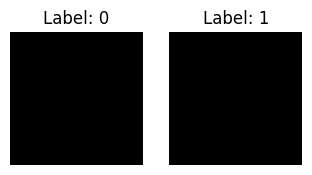

In [5]:
# Visualize sample images
def show_samples(dataset, n=6):
    plt.figure(figsize=(12, 6))
    i = 0
    for images, labels in dataset.take(1):
        for img, lbl in zip(images[:n], labels[:n]):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow(img.numpy().astype("uint8"))
            plt.title(f"Label: {int(lbl.numpy())}")
            plt.axis("off")
            i += 1
            if i >= n: break
    plt.show()

show_samples(train_ds)


In [6]:
# Build MobileNetV2 Model
def build_mobilenetv2_model(input_shape=IMG_SHAPE, trainable=False, dropout_rate=0.4, l2=1e-5):
    inp = layers.Input(shape=input_shape)
    base = tf.keras.applications.MobileNetV2(
        include_top=False, weights='imagenet',
        input_shape=input_shape, pooling='avg')
    base.trainable = trainable
    x = base(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate / 2)(x)
    out = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    model = keras.Model(inputs=inp, outputs=out, name="MobileNetV2_deepfake")
    return model

model = build_mobilenetv2_model(input_shape=IMG_SHAPE, trainable=False)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "MobileNetV2_deepfake"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,713 (9.26 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [7]:
# Compile and Train
metrics = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc")
]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=metrics
)

callbacks = [
    ModelCheckpoint(filepath="mobilenetv2_best.h5", monitor="val_auc", mode="max", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_auc", patience=6, mode="max", restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-7)
]

EPOCHS = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/30


I0000 00:00:1757225953.777312      68 service.cc:148] XLA service 0x78512c001de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757225953.778596      68 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757225953.778619      68 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757225954.921572      68 cuda_dnn.cc:529] Loaded cuDNN version 90300


   24/46927 ━━━━━━━━━━━━━━━━━━━━ 5:23 7ms/step - accuracy: 0.4381 - auc: 0.4276 - loss: 0.9260 - precision: 0.0817 - recall: 0.2072

I0000 00:00:1757225960.861879      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46921/46927 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7570 - auc: 0.6819 - loss: 0.5275 - precision: 0.4539 - recall: 0.2922
Epoch 1: val_auc improved from -inf to 0.64278, saving model to mobilenetv2_best.h5
46927/46927 ━━━━━━━━━━━━━━━━━━━━ 430s 9ms/step - accuracy: 0.7570 - auc: 0.6819 - loss: 0.5275 - precision: 0.4540 - recall: 0.2922 - val_accuracy: 0.7694 - val_auc: 0.6428 - val_loss: 0.7005 - val_precision: 0.3957 - val_recall: 0.3374 - learning_rate: 1.0000e-04
Epoch 2/30
46922/46927 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8175 - auc: 0.7650 - loss: 0.4444 - precision: 0.6912 - recall: 0.3047
Epoch 2: val_auc did not improve from 0.64278
46927/46927 ━━━━━━━━━━━━━━━━━━━━ 402s 9ms/step - accuracy: 0.8175 - auc: 0.7650 - loss: 0.4444 - precision: 0.6912 - recall: 0.3047 - val_accuracy: 0.7632 - val_auc: 0.6219 - val_loss: 0.7705 - val_precision: 0.3944 - val_recall: 0.3914 - learning_rate: 1.0000e-04
Epoch 3/30
46924/46927 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0

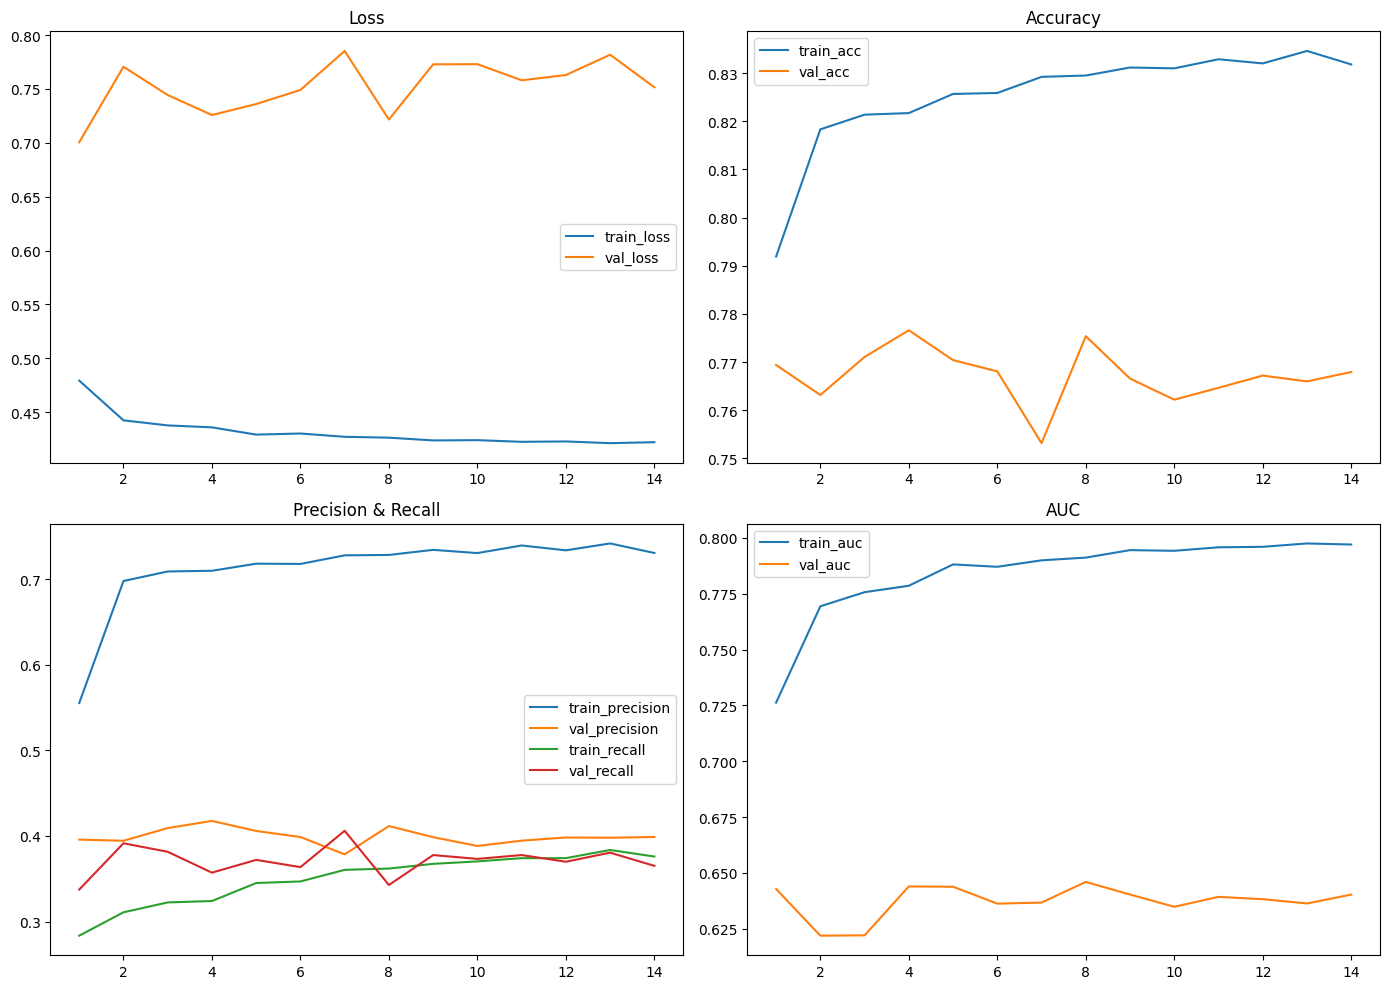

In [8]:
# Plot Training History
def plot_history(history):
    if history is None: return
    hist = history.history
    epochs_range = range(1, len(hist['loss']) + 1)
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs[0,0].plot(epochs_range, hist['loss'], label='train_loss')
    axs[0,0].plot(epochs_range, hist['val_loss'], label='val_loss')
    axs[0,0].set_title('Loss')
    axs[0,0].legend()
    axs[0,1].plot(epochs_range, hist['accuracy'], label='train_acc')
    axs[0,1].plot(epochs_range, hist['val_accuracy'], label='val_acc')
    axs[0,1].set_title('Accuracy')
    axs[0,1].legend()
    axs[1,0].plot(epochs_range, hist['precision'], label='train_precision')
    axs[1,0].plot(epochs_range, hist['val_precision'], label='val_precision')
    axs[1,0].plot(epochs_range, hist['recall'], label='train_recall')
    axs[1,0].plot(epochs_range, hist['val_recall'], label='val_recall')
    axs[1,0].set_title('Precision & Recall')
    axs[1,0].legend()
    axs[1,1].plot(epochs_range, hist['auc'], label='train_auc')
    axs[1,1].plot(epochs_range, hist['val_auc'], label='val_auc')
    axs[1,1].set_title('AUC')
    axs[1,1].legend()
    plt.tight_layout()
    plt.show()

plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━

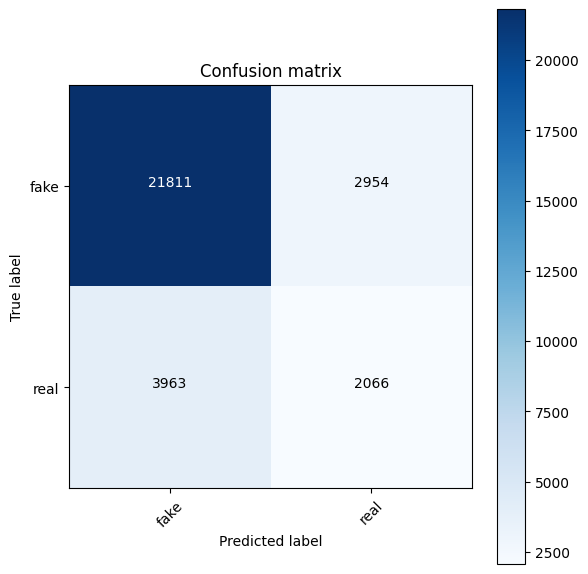

In [9]:
# Evaluation on validation set
y_true, y_pred_probs, y_pred_labels = [], [], []
for batch in val_ds:
    images, labels = batch
    probs = model.predict(images)
    labels_np = labels.numpy().astype(int).reshape(-1)
    probs_np = probs.reshape(-1)
    preds = (probs_np >= 0.5).astype(int)
    y_true.extend(labels_np.tolist())
    y_pred_probs.extend(probs_np.tolist())
    y_pred_labels.extend(preds.tolist())
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_labels = np.array(y_pred_labels)
print("Validation AUC:", roc_auc_score(y_true, y_pred_probs))
print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=["fake", "real"]))
cm = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["fake", "real"], rotation=45)
plt.yticks(tick_marks, ["fake", "real"])
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()
plt.show()


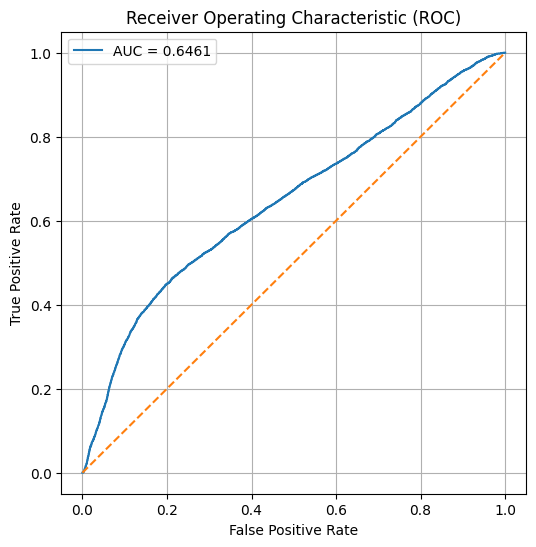

In [10]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Save the Trained Model
model.save("mobilenetv2_deepfake_model.h5")
model.save("mobilenetv2_deepfake_savedmodel")
if history is not None:
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv("mobilenetv2_training_history.csv", index=False)


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=mobilenetv2_deepfake_savedmodel.